# Organization and Visualization of fMRI Data

First we start with importing the libraries for downloading, organizing and visualizing the data which comes from the SPM homepage (http://www.fil.ion.ucl.ac.uk/spm/)

In [7]:
import requests
import zipfile
import pandas as pd
import numpy as np
import os
import nibabel
import matplotlib.pyplot as plt

# Enable plots inside the Jupyter Notebook
%matplotlib inline

Download the "Auditory - single subject" dataset from the SPM homepage

In [8]:
# Define the URL of the data and download it using the Requests libary
url = 'http://www.fil.ion.ucl.ac.uk/spm/download/data/MoAEpilot/MoAEpilot.zip'
data = requests.get(url)

# Check if the targed folder for storing the data already exists. If not create it and save the zip file.
if os.path.exists('./fMRI_data') == False:
    os.mkdir('fMRI_data')
    
open('./fMRI_data/data.zip', 'wb').write(data.content)

# Un-zip the file
zip_ref = zipfile.ZipFile('./fMRI_data/data.zip', 'r')
zip_ref.extractall('./fMRI_data/')
zip_ref.close()

Un-zipping the file gives us two folders with various files inside them. The first folder ("./sM00223/") contains a high resolution structural scan of the subject. Visualizing the high-res anatomy data works in principal the same way as the functional data except that it has no 4th time dimension. The functional data is located in the other folder ("./fM00223/"). Looking at the structural scan, we can read using the the NiBabel package.

In [9]:
# Find all files in the structural data folder
data_path = './fMRI_data/sM00223/'
files = os.listdir(data_path)

# Read in the data
data_all = []
for data_file in files:
    if data_file[-3:] == 'hdr':
        data = nibabel.load(data_path + data_file).get_data()

Checking the dimensionality of the data,

In [11]:
print(data.shape)

(256, 256, 54, 1)


This means that each image is 256 by 256 voxels in size and there were 54 slices collected. Since the 4th dimension doesn't contain any information, it can be dropped. We will also rotate the data.

In [12]:
data = np.rot90(data.squeeze(), 1)
print(data.shape)

(256, 256, 54)


Looking at every 10th slice of the scan,

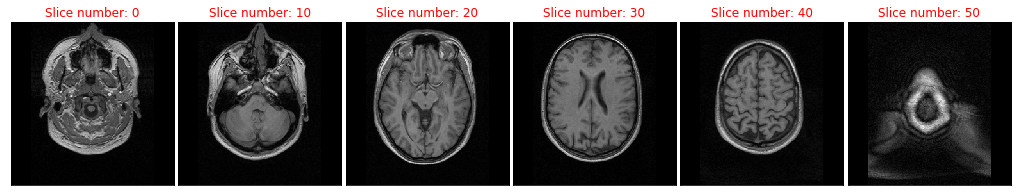

In [13]:
fig, ax = plt.subplots(1, 6, figsize=[18, 3])

n = 0
slice = 0
for _ in range(6):
    ax[n].imshow(data[:, :, slice], 'gray')
    ax[n].set_xticks([])
    ax[n].set_yticks([])
    ax[n].set_title('Slice number: {}'.format(slice), color='r')
    n += 1
    slice += 10
    
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

The orientation we are looking at the subject from is from the top with slice 0 being the lowest and slice 50 being the highest. In slice 20 you can see eyes

Looking at the functional data, from the README.txt file that comes with the dataset, the details of the data acquisition which we need to read are documented. The key parameters we have to know are the size of each image, the number of slices that were collected, and how many volumes were acquired; that is the number of timepoints that were sampled.

In [14]:
# Basic information about the data acquisition
x_size = 64
y_size = 64
n_slice = 64
n_volumes = 96

# Find all files in the data folder
data_path = './fMRI_data/fM00223/'
files = os.listdir(data_path)

# Read in the data and organize it with respect to the acquisition parameters
data_all = []
for data_file in files:
    if data_file[-3:] == 'hdr':
        data = nibabel.load(data_path + data_file).get_data()        
        data_all.append(data.reshape(x_size, y_size, n_slice))

The data now has three spatial dimentions and one temporal dimention. meaning it is not possible to see everything at once. Selecting a plane in which we can "cut" the brain, we will choose the three planes commonly used to transect the brain: coronal, transversal, and sagittal. All the spatial dimensions are the same (64x64x64) voxels so we just need to re-organize and rotate the data to get images.

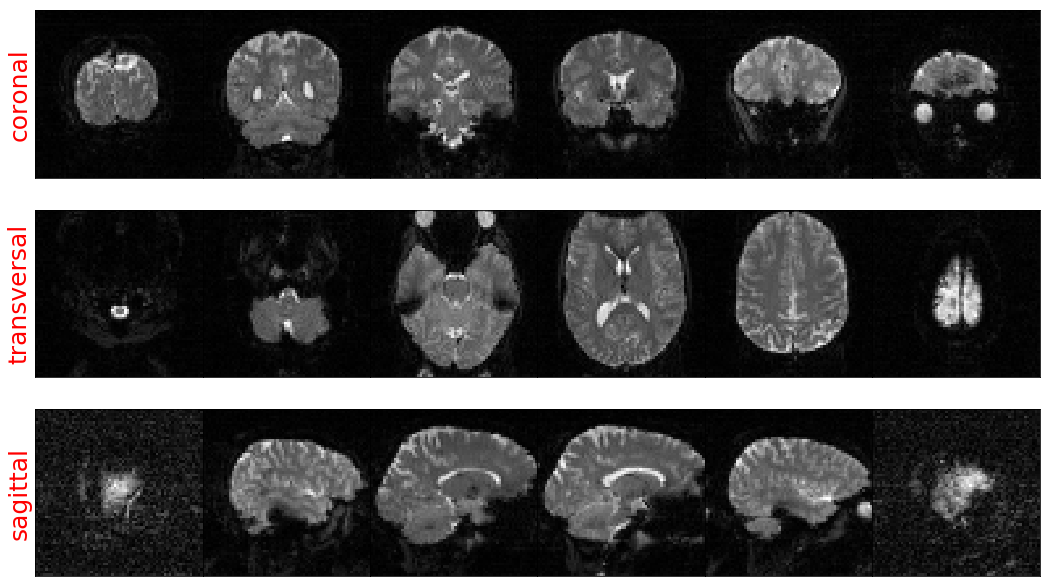

In [15]:
# Create a 3x6 subplot 
fig, ax = plt.subplots(3, 6, figsize=[18, 11])

# Organize the data for visualisation in the coronal plane
coronal = np.transpose(data_all, [1, 3, 2, 0])
coronal = np.rot90(coronal, 1)

# Organize the data for visualisation in the transversal plane
transversal = np.transpose(data_all, [2, 1, 3, 0])
transversal = np.rot90(transversal, 2)

# Orgaize the data for visualisation in the sagittal plane
sagittal = np.transpose(data_all, [2, 3, 1, 0])
sagittal = np.rot90(sagittal, 1)

# Plot some of the images in different planes
n = 10
for i in range(6):
    ax[0][i].imshow(coronal[:, :, n, 0], cmap='gray')
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])
    if i == 0:
        ax[0][i].set_ylabel('coronal', fontsize=25, color='r')
    n += 10
    
n = 5
for i in range(6):
    ax[1][i].imshow(transversal[:, :, n, 0], cmap='gray')
    ax[1][i].set_xticks([])
    ax[1][i].set_yticks([])
    if i == 0:
        ax[1][i].set_ylabel('transversal', fontsize=25, color='r')
    n += 10
    
n = 5
for i in range(6):
    ax[2][i].imshow(sagittal[:, :, n, 0], cmap='gray')
    ax[2][i].set_xticks([])
    ax[2][i].set_yticks([])
    if i == 0:
        ax[2][i].set_ylabel('sagittal', fontsize=25, color='r')
    n += 10

fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

Looking at the temporal domain, since we will not get a nice image of the brain, this will be trickier in terms of visualization. Here we will pick any voxel in any slice and plot its time course

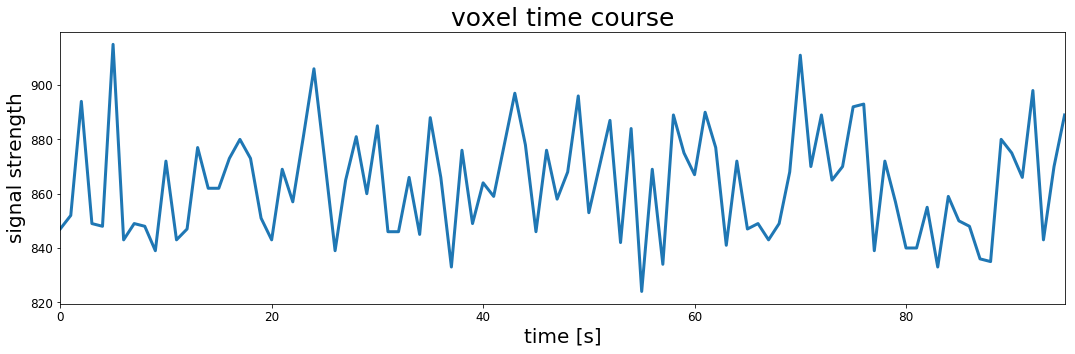

In [16]:
# Create an empty plot with defined aspect ratio
fig, ax = plt.subplots(1, 1, figsize=[18, 5])

# Plot the timecourse of a random voxel
ax.plot(transversal[30, 30, 35, :], lw=3)
ax.set_xlim([0, transversal.shape[3]-1])
ax.set_xlabel('time [s]', fontsize=20)
ax.set_ylabel('signal strength', fontsize=20)
ax.set_title('voxel time course', fontsize=25)
ax.tick_params(labelsize=12)

plt.show()

Creating one .csv file for each slive that contains the spatial and temporal dimensions. With only two dimensions, we will reshape each slice into a MxN matrix where M = y_size * x_size and N = n_volumes. When we read the files again this must be reversed.

Slice by slice .csv files are not the way you store fMRI data these days, but it's easier to get the general idea of how the data can be organized and rearranged.

In [20]:
# Rearrange and reshape data for export
data_all = np.transpose(data_all, [3, 2, 1, 0])
data_all = np.reshape(data_all, [n_slice, y_size*x_size, n_volumes])

# Check if output path exists, if not create it.
if os.path.exists('./fMRI_data/csv_data') == False:
    os.mkdir('./fMRI_data/csv_data')

# Export each slice as a .csv file 
n = 0
for export in data_all:

    save_file = 'slice_{}.csv'.format(n)
    save_path = './fMRI_data/csv_data/{}'.format(save_file)
    pd.DataFrame(export).to_csv(save_path, header=False, index=False)
    n += 1